# Object Detector

## Домашнее задание

1. Вам нужно будет загрузить и оформить датасет котиков, собак https://www.kaggle.com/andrewmvd/dog-and-cat-detection 
2. *Нужно будет произвести аугментацию данных
3. Затем обучить нейронную сеть на получившемся датасете



Хорошая статья на эту тему.-- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Информация об аугиментациях взята отсюда- https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/


https://habr.com/ru/post/478208/

## Description. 

Create a detection model for dogs and cats

Larxel · 0 Submissions

Summary

We have two different classes and their bounding boxes.
You can create a model for object detection to find the localization of the pets within the image!
Architecture Suggestions

In [1]:
# скачаем и загрузим датасет 

In [2]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import models
from torchvision import transforms

### Загрузка данных

Описания для каждого изображения хранятся в отдельных файлах XML. Сделаем следующие шаги для подготовки данных для тренировки:  

* Пройдемся по директории annotations что бы получить все файлы .xml
* Прочитаем нужную нам информацию из каждого файла .xml используя xml.etree.ElementTree
* Создадим словарь содержащий filepath(путь до картинки), width, height, (xmin , xmax , ymin , ymax) (кординаты bounding box'a) и class и добавим словарь в список.
* Создадим pandas dataframe используя список словарей из прошлого пункта

In [3]:
import xml.etree.ElementTree as ET

In [4]:
images_path = Path('./pet_detection/images')
anno_path = Path('./pet_detection/annotations')


def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [5]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,pet_detection/images/Cats_Test2545.png,334,500,dog,65,27,287,216
1,pet_detection/images/Cats_Test453.png,375,500,dog,79,235,286,469
2,pet_detection/images/Cats_Test3013.png,422,500,cat,150,44,367,221
3,pet_detection/images/Cats_Test917.png,500,348,dog,72,19,434,342
4,pet_detection/images/Cats_Test3661.png,500,333,dog,166,37,323,256
...,...,...,...,...,...,...,...,...
3681,pet_detection/images/Cats_Test3636.png,334,500,cat,63,47,217,207
3682,pet_detection/images/Cats_Test445.png,500,439,cat,98,11,317,242
3683,pet_detection/images/Cats_Test530.png,300,300,cat,42,10,255,205
3684,pet_detection/images/Cats_Test2518.png,500,328,dog,134,22,373,253


In [6]:
df_train['class'].value_counts()

dog    2498
cat    1188
Name: class, dtype: int64

Приведем значения в колонке 'class' (метки классов) к бинаронму виду.

In [7]:
clases = ['cat','dog']

In [8]:
class_dict = {'cat':0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x: class_dict[x])

df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,pet_detection/images/Cats_Test2545.png,334,500,1,65,27,287,216
1,pet_detection/images/Cats_Test453.png,375,500,1,79,235,286,469
2,pet_detection/images/Cats_Test3013.png,422,500,0,150,44,367,221
3,pet_detection/images/Cats_Test917.png,500,348,1,72,19,434,342
4,pet_detection/images/Cats_Test3661.png,500,333,1,166,37,323,256


In [9]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)


def create_mask(bb, x):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(x):
    """Генерируем массив bounding box'a из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])


def resize_image_bb(read_path, write_path, bb, sz):
    """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

(375, 500, 3)


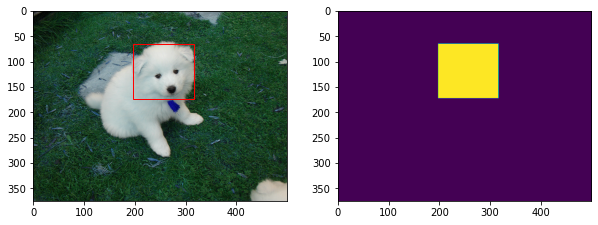

In [22]:
number = 58
im = cv2.imread(str(df_train.values[number][0]))
bb = create_bb_array(df_train.values[number])
print(im.shape)

Y = create_mask(bb, im)
rect = plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0],fill=False, color='red')

fig, ax = plt.subplots(1,2,figsize=(10,7))
ax[0].imshow(im)
ax[0].add_patch(rect)
ax[1].imshow(Y)
plt.show()

Приведем все изображения в датасете к единому размеру. 256х256 p. 
Сохраним отресайзенные изображения в папку "images_resized".

In [26]:
IM_SIZE = 256

new_paths = []
new_bbs = []
train_path_resized = Path('./pet_detection/images_resized')
Path.mkdir(train_path_resized, exist_ok=True)


for index, row in tqdm(df_train.iterrows()):
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

df_train.head()

3686it [02:10, 28.18it/s]


,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,pet_detection/images/Cats_Test2545.png,334,500,1,65,27,287,216,pet_detection/images_resized/Cats_Test2545.png,"[14.0, 49.0, 110.0, 219.0]"
1,pet_detection/images/Cats_Test453.png,375,500,1,79,235,286,469,pet_detection/images_resized/Cats_Test453.png,"[120.0, 54.0, 239.0, 195.0]"
2,pet_detection/images/Cats_Test3013.png,422,500,0,150,44,367,221,pet_detection/images_resized/Cats_Test3013.png,"[22.0, 91.0, 112.0, 222.0]"
3,pet_detection/images/Cats_Test917.png,500,348,1,72,19,434,342,pet_detection/images_resized/Cats_Test917.png,"[14.0, 37.0, 251.0, 221.0]"
4,pet_detection/images/Cats_Test3661.png,500,333,1,166,37,323,256,pet_detection/images_resized/Cats_Test3661.png,"[28.0, 85.0, 196.0, 165.0]"


In [27]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=2)

In [28]:
def show_corner_bb(im, bb,bb_true=None):
    plt.imshow(im)
    if bb_true is not None:
        plt.gca().add_patch(create_corner_rect(bb_true,color='blue'))
    plt.gca().add_patch(create_corner_rect(bb))

pet_detection/images_resized/Cats_Test3300.png


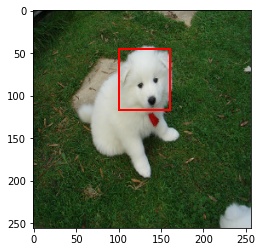

In [29]:
number = 58
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])

## Аугментация данных

In [31]:
affine_transforms = transforms.Compose([
                               transforms.Resize(size=(IM_SIZE, IM_SIZE), ),
                               transforms.RandomRotation(degrees=90),
])


image_transforms = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                        std=[0.229, 0.224, 0.225])

In [32]:
def get_image(path, bb, is_transforms):
    image = cv2.imread(str(path)).astype(np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255
    mask = create_mask(bb, image)
    
    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)    
    stacked = torch.cat([image, mask], dim=0)  # shape=(4xHxW)
    if is_transforms:
        stacked = affine_transforms(stacked)   

  # Split them back up again
    image = stacked[:3]
    mask = stacked[-1]
   
    # При выполнении нормализации изображений в датасете качество обучения ужудшилось. => Обойдемся без нее.
    # image = image_transforms(image) 

    bb = mask_to_bb(mask.numpy())

    return image, bb

def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]

Наш кастомный Dataset

In [33]:
class Cat_Dog_Dataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = get_image(path, self.bb[idx], self.is_transforms)
        return x, y_class, y_bb

Разделим датасет на тренировочную и тестовую выборки.

In [34]:
X_train, X_val, y_train, y_val = train_test_split(df_train[['new_path', 'new_bb']], df_train['class'], test_size=0.2, random_state=42)

Создадим для тренировочной и тестовой выборки датасеты.

In [35]:
train_ds = Cat_Dog_Dataset(X_train['new_path'], X_train['new_bb'], y_train, is_transforms=True)
valid_ds = Cat_Dog_Dataset(X_val['new_path'], X_val['new_bb'], y_val)

In [36]:
train_batch_size = 16
val_batch_size = 16

train_dl = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=val_batch_size)

Проверим работу DataLoader

dog


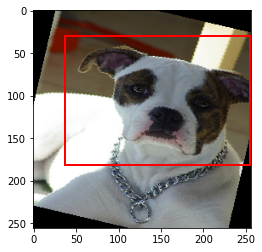

In [37]:
ind= 0

for x, y_class, y_bb in train_dl:
    break

print(clases[y_class[ind]])
show_corner_bb(x[ind].permute(1, 2, 0), y_bb[ind])

cat


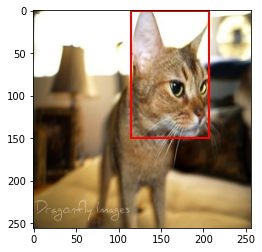

In [38]:
ind= 7

for x, y_class, y_bb in valid_dl:
    break

print(clases[y_class[ind]])
show_corner_bb(x[ind].permute(1, 2, 0), y_bb[ind])

### Настройка параметров модели.

In [39]:
class_length = len(clases)
class_length

2

In [40]:
bb_len=4

In [41]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)

        for param in resnet.parameters():  # Зафиксируем веса resnet34.
          param.requires_grad = False

        layers = list(resnet.children())[:8] 
        self.features = nn.Sequential(*layers)

        self.classifier = nn.Sequential(
                                nn.BatchNorm1d(512), 
                                nn.Linear(512, class_length)
                              )

        self.bb = nn.Sequential(
                          nn.BatchNorm1d(512),
                          nn.Linear(512, bb_len)
                        )
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [43]:
model = BB_model().to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)
epochs = 15

dog


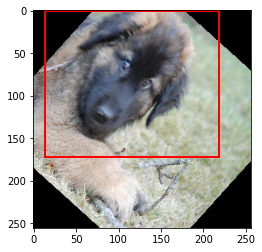

In [44]:
ind= 7

for x, y_class, y_bb in train_dl:
    break

print(clases[y_class[ind]])
show_corner_bb(x[ind].permute(1, 2, 0), y_bb[ind])

### Обучение модели

In [45]:
def fit():
    for i in range(epochs):

        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            len_batch = y_class.shape[0]
            x = x.to(device).float()
            y_class = y_class.to(device)
            y_bb = y_bb.to(device).float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total
#==============================================================================
        # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            len_batch = y_class.shape[0]
            x = x.to(device).float()
            y_class = y_class.to(device)
            y_bb = y_bb.to(device).float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total
        print(f"Epoch [{i+1}/{epochs}]. loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")

In [46]:
fit()

/home/sergey/anaconda3/envs/imageai_env/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch [1/15]. loss 440.131 val_loss 332.077 val_acc 0.988
Epoch [2/15]. loss 255.843 val_loss 130.802 val_acc 0.989
Epoch [3/15]. loss 141.860 val_loss 131.459 val_acc 0.988
Epoch [4/15]. loss 134.771 val_loss 128.219 val_acc 0.989
Epoch [5/15]. loss 131.002 val_loss 123.453 val_acc 0.992
Epoch [6/15]. loss 126.628 val_loss 121.400 val_acc 0.989
Epoch [7/15]. loss 124.436 val_loss 117.493 val_acc 0.984
Epoch [8/15]. loss 122.045 val_loss 117.439 val_acc 0.985
Epoch [9/15]. loss 122.340 val_loss 115.112 val_acc 0.984
Epoch [10/15]. loss 117.902 val_loss 114.961 

### Проверка качества обучения. 

In [47]:
image_name = 'my_cat.jpg'
new_image_name = 'my_cat_1.jpg'

im = read_image(image_name)
im_resized = cv2.resize(im, (IM_SIZE, IM_SIZE))

In [48]:
image = TF.to_tensor(im_resized)

cat


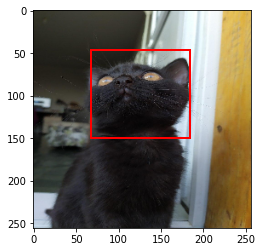

In [49]:
# prediction
out_class, out_bb = model(image[None,].cuda())

_, prerds = torch.max(out_class, axis= -1)
prerds
print(clases[prerds])

# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(image.permute(1, 2, 0), bb_hat[0])

In [50]:
image_name = 'my_cat.jpg'
new_image_name = 'my_cat_1.jpg'

im = read_image(image_name)
im_resized = cv2.resize(im, (IM_SIZE, IM_SIZE))
cv2.imwrite(new_image_name, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))

True

In [51]:
temp_df = df_train.loc[(df_train['new_path'] == 'pet_detection/images_resized/Cats_Test2.png')]

In [52]:
test_ds = Cat_Dog_Dataset(temp_df['new_path'],
                          temp_df['new_bb'], 
                          temp_df['class'])

In [53]:
x, y_class, y_bb = test_ds[0]

In [54]:
# prediction
out_class, out_bb = model(x[None,].cuda().float())

_, prerds = torch.max(out_class, axis= -1)

dog


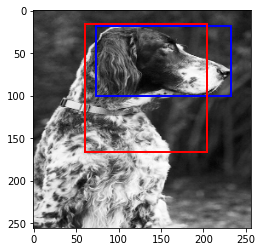

In [55]:
print(clases[prerds])

# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(x.permute(1, 2, 0), bb_hat[0],bb_true=y_bb)

In [56]:
temp_df = df_train.loc[(df_train['new_path'] == 'pet_detection/images_resized/Cats_Test8.png')]

In [57]:
test_ds = Cat_Dog_Dataset(temp_df['new_path'], temp_df['new_bb'], temp_df['class'])

In [58]:
x, y_class, y_bb = test_ds[0]

In [59]:
out_class, out_bb = model(x[None,].cuda().float())

_, prerds = torch.max(out_class, axis= -1)

dog


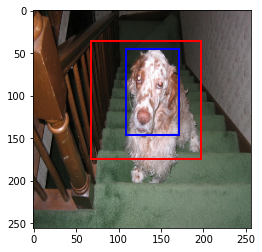

In [60]:
print(clases[prerds])

# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
y_bb = y_bb.astype(int)
show_corner_bb(x.permute(1, 2, 0), bb_hat[0],bb_true=y_bb)

### Выводы:

Модель хорошо угадыват класс объекта, а также пололжение bounding box. Но, с геометрией ограничиающего прямоугольника есть проблемы. Он для всех объектов имеет ворму квадрата, хотя, в реальности это не так. 